# First question : Who are people talking about cinema, regarding gender and age ?

In [1]:
import pandas as pd
import bz2
import json
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime, date
from dateutil import relativedelta

from ressources import config

In [2]:
def parse_date(date):
    try:
        if not isinstance(date, str):
            return np.NaN
        elif len(date)%10 != 0:
            return np.NaN
        elif date == 'None' or date[0] == '-':
            return np.NaN
        elif '00.00.0000' in date[0:10] :
            return '01.01.0001'
        elif '00.0000' in date[0:10] :
            return datetime.strptime(date[0:10], '%d.00.0000').strftime('%d.%m.%Y')
        elif '0000' in date[0:10] :
            return datetime.strptime(date[0:10], '%d.%m.0000').strftime('%d.%m.%Y')
        elif '+1939-02-29T00:00:00Z' in date:
            return '28.02.1939'
        elif '0' in date[6]: 
            return np.NaN
        elif '00' in date[6:7]: 
            return np.NaN
        else :
            return datetime.strptime(date[0:10], '%d.%m.%Y').strftime('%d.%m.%Y')
    except ValueError as e:
        if str(e) == 'day is out of range for month':
            return datetime.strptime(date[0:8], '%Y.%m').strftime('%d.%m.%Y')
        else:
            print(date)
            raise e

## Task 1

We first import the data. A dataframe with url containing the key words 'movies', 'films' and 'cinema' were extracted from Quotebank in a json file.

Summary of the features:

- quoteID : primary key of the quotation
- quotation : text of the longest encountered original form of the quotation
- speaker : selected most likely speaker. This matches the the first speaker entry in `probas`
- qids : wikidata IDs of all aliases that match the selected speaker
- date : earliest occurrence date of any version of the quotation
- numOccurences : number of time this quotation occurs in the articles
- probas : array representing the probabilities of each speaker having uttered the quotation.
- urls : list of links to the original articles containing the quotation 
- phase : corresponding phase of the data in which the quotation first occurred (A-E)

Unattributed quotes has already been filtered. Indeed, it is not relevant to take the second most likely person, since it make no sense to take a a more likely speaker than no one.

In [14]:
# Loading the dataframe to have a look on the data
path_to_file = '../generated/QUOTEBANK/movie_quotes-2018.json.bz2'

df_movie_quote = pd.read_json(path_to_file, lines=True, compression='bz2')
df_movie_quote.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,dob
0,2018-12-06-000021,... a race to see who could sail around the wo...,James Marsh,"[Q2720543, Q41757028, Q56510432, Q6138937, Q99...",2018-12-06 12:00:34,1,"[[James Marsh, 0.6787], [None, 0.3213]]",[http://filmthreat.com/reviews/the-mercy/],E,male,30.04.1963
1,2018-05-06-000178,... never as fascinating as the philosophy or ...,Ed Moy,[Q26828697],2018-05-06 01:00:55,1,"[[Ed Moy, 0.7867], [None, 0.2133]]",[http://filmthreat.com/reviews/luminaries/],E,male,None
2,2018-07-09-000437,"$100,000 to punch me in the face right now.",Johnny Depp,[Q37175],2018-07-09 21:26:13,4,"[[Johnny Depp, 0.5001], [None, 0.4624], [Brad ...",[https://www.vanityfair.com/hollywood/2018/07/...,E,male,09.06.1963
3,2018-03-16-002261,A lot of it is pure entertainment but the film...,Tim White,"[Q15443196, Q16762431, Q18164313, Q18600422, Q...",2018-03-16 09:30:00,1,"[[Tim White, 0.912], [None, 0.088]]",[http://www.capitalgazette.com/entertainment/a...,E,male,None
4,2018-05-20-000976,A moment during the making of Raazi. Words can...,Alia Bhatt,[Q4725343],2018-05-20 11:01:19,2,"[[Alia Bhatt, 0.8059], [None, 0.1805], [Ashwin...",[https://www.thestatesman.com/entertainment/bo...,E,female,15.03.1993


In [15]:
#drop columns that aren't relevant for the question
df_movie_quote.drop(['qids', 'probas', 'urls', 'phase', 'quoteID'], axis = 1, inplace = True)

In [16]:
df_movie_quote.head()

,quotation,speaker,date,numOccurrences,gender,dob
0,... a race to see who could sail around the wo...,James Marsh,2018-12-06 12:00:34,1,male,30.04.1963
1,... never as fascinating as the philosophy or ...,Ed Moy,2018-05-06 01:00:55,1,male,None
2,"$100,000 to punch me in the face right now.",Johnny Depp,2018-07-09 21:26:13,4,male,09.06.1963
3,A lot of it is pure entertainment but the film...,Tim White,2018-03-16 09:30:00,1,male,None
4,A moment during the making of Raazi. Words can...,Alia Bhatt,2018-05-20 11:01:19,2,female,15.03.1993


## Task 2

describing data

In [17]:
len(df_movie_quote)

427368

In [18]:
df_movie_quote.describe()

,numOccurrences
count,427368.000000
mean,8.379535
std,101.513069
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,50159.000000


## Task 3

Age of the speakers at the moment of the citation need to be calculated from date of birth.

In [19]:
df_movie_age = df_movie_quote.copy()
df_movie_age.head()

,quotation,speaker,date,numOccurrences,gender,dob
0,... a race to see who could sail around the wo...,James Marsh,2018-12-06 12:00:34,1,male,30.04.1963
1,... never as fascinating as the philosophy or ...,Ed Moy,2018-05-06 01:00:55,1,male,None
2,"$100,000 to punch me in the face right now.",Johnny Depp,2018-07-09 21:26:13,4,male,09.06.1963
3,A lot of it is pure entertainment but the film...,Tim White,2018-03-16 09:30:00,1,male,None
4,A moment during the making of Raazi. Words can...,Alia Bhatt,2018-05-20 11:01:19,2,female,15.03.1993


In [20]:
#transforme column date in the right format
df_movie_age['date'] = df_movie_age['date'].astype(str).map(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%d.%m.%Y'))

In [21]:
df_movie_age['dob'] = df_movie_age['dob'].map(parse_date)
df_movie_age.head()

,quotation,speaker,date,numOccurrences,gender,dob
0,... a race to see who could sail around the wo...,James Marsh,06.12.2018,1,male,30.04.1963
1,... never as fascinating as the philosophy or ...,Ed Moy,06.05.2018,1,male,NaN
2,"$100,000 to punch me in the face right now.",Johnny Depp,09.07.2018,4,male,09.06.1963
3,A lot of it is pure entertainment but the film...,Tim White,16.03.2018,1,male,NaN
4,A moment during the making of Raazi. Words can...,Alia Bhatt,20.05.2018,2,female,15.03.1993


In [22]:
df_movie_age = df_movie_age[df_movie_age['dob'].notna()]
df_movie_age.head()

,quotation,speaker,date,numOccurrences,gender,dob
0,... a race to see who could sail around the wo...,James Marsh,06.12.2018,1,male,30.04.1963
2,"$100,000 to punch me in the face right now.",Johnny Depp,09.07.2018,4,male,09.06.1963
4,A moment during the making of Raazi. Words can...,Alia Bhatt,20.05.2018,2,female,15.03.1993
6,Absolutely in sync. Fantastic.,Shirley Ballas,27.10.2018,1,female,17.09.1960
8,almost as a direct result of colonisation,Ryan Coogler,19.02.2018,1,male,23.05.1986


In [23]:
df_movie_age['date_year'] = df_movie_age['date'].str[6:]

In [24]:
df_movie_age['dob_year'] = df_movie_age['dob'].str[6:]

In [26]:
df_movie_age['date_year'] = df_movie_age['date_year'].astype(int)
df_movie_age['dob_year'] = df_movie_age['dob_year'].astype(int)

In [27]:
df_movie_age['age'] = df_movie_age['date_year'] - df_movie_age['dob_year']
df_movie_age.head()

,quotation,speaker,date,numOccurrences,gender,dob,date_year,dob_year,age
0,... a race to see who could sail around the wo...,James Marsh,06.12.2018,1,male,30.04.1963,2018,1963,55
2,"$100,000 to punch me in the face right now.",Johnny Depp,09.07.2018,4,male,09.06.1963,2018,1963,55
4,A moment during the making of Raazi. Words can...,Alia Bhatt,20.05.2018,2,female,15.03.1993,2018,1993,25
6,Absolutely in sync. Fantastic.,Shirley Ballas,27.10.2018,1,female,17.09.1960,2018,1960,58
8,almost as a direct result of colonisation,Ryan Coogler,19.02.2018,1,male,23.05.1986,2018,1986,32


## Task 4

Analysing data :
- Group by age and gender
- Create visualisations

In [28]:
df_movie_quote.groupby(['gender','speaker']).count()

quotation  date  numOccurrences  dob
gender speaker                                            
female A. Mayer               5     5               5    5
       ABBEY Clancy           1     1               1    1
       AISHWARYA RAI          1     1               1    1
       AJ Mendez              1     1               1    1
       ALEX MURREL            1     1               1    1
...                         ...   ...             ...  ...
other  de Andrade             1     1               1    0
       g. Matt                7     7               7    0
       m. Paul                1     1               1    0
       t Shah                 1     1               1    0
       tan Lee                1     1               1    0

[52448 rows x 4 columns]

Text(0.5, 0, 'Number of speakers')

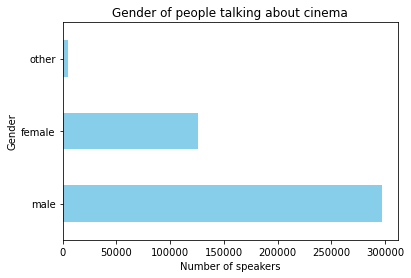

In [29]:
df_movie_quote['gender'].value_counts().plot.barh(color = 'skyblue')

plt.title("Gender of people talking about cinema")
plt.ylabel("Gender")
plt.xlabel("Number of speakers")
#plt.savefig('./Plot_speaker_by_gender.png', bbox_inches='tight')

This bar plot indicates there are more men who talk about cinema than women.

In [31]:
df_movie_age[df_movie_age['age'] > 100].head()

,quotation,speaker,date,numOccurrences,gender,dob,date_year,dob_year,age
144,Start to think positive so positive things can...,William Stewart,18.07.2018,8,male,01.01.1882,2018,1882,136
228,"And that process, it was a little bigger. We w...",Robert Armstrong,27.04.2018,1,male,07.04.1917,2018,1917,101
334,Our handbags are laughing at the idea of the h...,Fernando Garcia,14.02.2018,1,male,22.07.1917,2018,1917,101
355,the festival's production crew is made up of m...,Robert Small,25.01.2018,2,male,14.04.1873,2018,1873,145
381,Until major media companies take concrete step...,Stacy Smith,09.01.2018,1,male,01.01.1901,2018,1901,117


__Discuss__ : There are people over 100 years old that are related to quotation from 2018. Indeed, a newspaper can quote a person several years after that person has spoken.

Text(0, 0.5, 'Occurence')

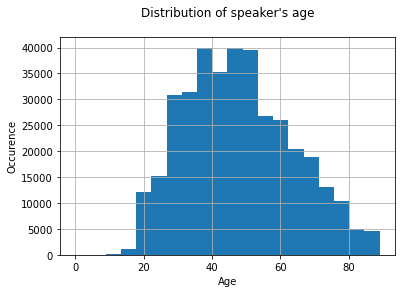

In [32]:
df_movie_age_filtered = df_movie_age[df_movie_age['age'] < 90]
df_movie_age_filtered.sort_values(by = ['age'])

df_movie_age_filtered['age'].hist(bins = 20)

plt.title("Distribution of speaker's age\n")
plt.xlabel('Age')
plt.ylabel('Occurence')